# Toy experiments
  
    
    
In this notebook, we perform initial experiments to demonstrate the 'Curse of Chaos' occuring in a simple function

$f(x) = 0.1 \sin{\frac{x \omega}{\pi}} + (\frac{x}{10})^2 + 0.1$

From this function, we want to compute the gradient of its expectation, w.r.t samples taken from a normal distribution $x \sim \mathcal{N}(\mu, \sigma)$

$\nabla_{\theta} \mathbb{E}_{x \sim p(x; \theta)} [f(x)]$

To do this, use two different gradient estimation techniques:<br>
- Reparametrized gradients, which we show have high variance
- Likelihood ratio gradients, which have lower variance in chaotic environments

In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt

from toy_function import foo, mc_function, linear_foo, mc_linear_foo
from reparametrization import (
    get_rp_grad_var,
    get_rp_gradients,
    get_rp_linear_foo_gradients,
    get_rp_linear_foo_grad_var,
)
from scoregradient import (
    get_lr_grad_var,
    get_lr_gradients,
    get_lr_linear_foo_gradients,
    get_lr_linear_foo_grad_var,
)
from combined_gradients import get_combined_grad_var
from constants import (
    RANGE_START, RANGE_END, NUM_INPUTS, VARIANCE, N, NUM_BATCHES
)

## Visualizing the function

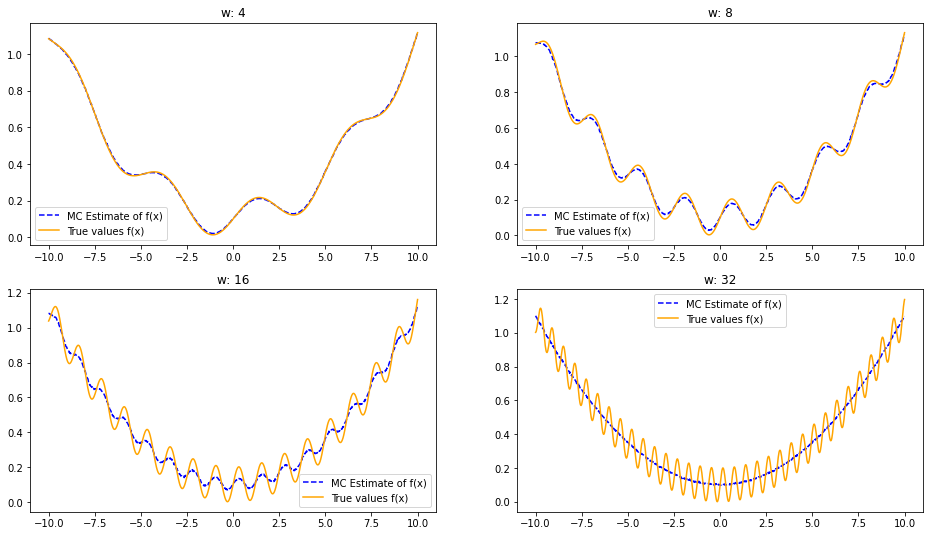

In [2]:
xs = jnp.linspace(RANGE_START, RANGE_END, NUM_INPUTS)

mc_f = jnp.zeros((3, NUM_INPUTS))
true_f = jnp.zeros((3, NUM_INPUTS))

fig = plt.figure(figsize=(16, 9))
ax = fig.subplots(2, 2)

w = 4
for i in range(2):
    for j in range(2):
        mc_f = mc_function(VARIANCE, xs, w, N, NUM_INPUTS)
        true_f = foo(xs, w)

        ax[i,j].plot(xs, mc_f, color='blue', label='MC Estimate of f(x)', linestyle='dashed')
        ax[i,j].plot(xs, true_f, color='orange', label='True values f(x)')
        ax[i,j].legend()
        ax[i,j].set_title(f"w: {w}")
        
        w = 2 * w
    
plt.show()

## Visualizing Gradient variance with different estimators

In [3]:
def get_grad_variances(oscillations, xs, means, variances):
    rp_grad_vars = np.zeros((oscillations.shape[0], 2))
    lr_grad_vars = np.zeros((oscillations.shape[0], 2))
    lr_baseline_grad_vars = np.zeros((oscillations.shape[0], 2))
    combined_grad_vars = np.zeros((oscillations.shape[0], 2))
    for i, w in enumerate(oscillations):
        if i % 10 == 0:
            print(f"Step: {i}")

        # RP gradients        
        rp_mu_grad_var, rp_var_grad_var = get_rp_grad_var(means, variances, w, N, NUM_INPUTS, NUM_BATCHES)
        
        rp_grad_vars[i, 0] = rp_mu_grad_var.mean()
        rp_grad_vars[i, 1] = rp_var_grad_var.mean()
        
        # LR gradients            
        lr_mu_grad_var, lr_var_grad_var = get_lr_grad_var(means, variances, xs, w, N, NUM_INPUTS, NUM_BATCHES)
        
        lr_grad_vars[i, 0] = lr_mu_grad_var.mean()
        lr_grad_vars[i, 1] = lr_var_grad_var.mean()
        
        # LR gradients with baseline        
        lr_b_mu_grad_var, lr_b_var_grad_var = get_lr_grad_var(
                                                    means,
                                                    variances,
                                                    xs,
                                                    w,
                                                    N,
                                                    NUM_INPUTS,
                                                    NUM_BATCHES,
                                                    baseline=True,
                                                )
        
        lr_baseline_grad_vars[i, 0] = lr_b_mu_grad_var.mean()
        lr_baseline_grad_vars[i, 1] = lr_b_var_grad_var.mean()
        
        # Naive combination of LR and RP
        combined_mu_grad_var, combined_var_grad_var = get_combined_grad_var(means, variances, xs, w, N, NUM_INPUTS)
        combined_grad_vars[i, 0] = combined_mu_grad_var.mean()
        combined_grad_vars[i, 1] = combined_var_grad_var.mean()
        
    return rp_grad_vars, lr_grad_vars, lr_baseline_grad_vars, combined_grad_vars


In [4]:
xs = jnp.linspace(RANGE_START, RANGE_END, NUM_INPUTS)
oscillations = jnp.linspace(2, 1000, 100)

means = jnp.stack([jnp.full((N,), x) for x in xs])
variances = jnp.full((NUM_INPUTS, N), VARIANCE)

rp_grad_vars, lr_grad_vars, lr_baseline_grad_vars, combined_grad_vars = get_grad_variances(
                                                        oscillations,
                                                        xs,
                                                        means,
                                                        variances
                                                    )

rp_mu = rp_grad_vars[:, 0]
rp_var = rp_grad_vars[:, 1]

lr_mu = lr_grad_vars[:, 0]
lr_var = lr_grad_vars[:, 1]

lr_baseline_mu = lr_baseline_grad_vars[:, 0]
lr_baseline_var = lr_baseline_grad_vars[:, 1]

combined_mu = combined_grad_vars[:, 0]
combined_var =combined_grad_vars[:, 0]

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90


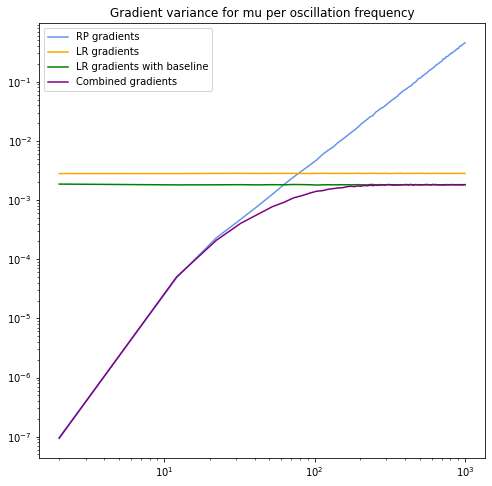

In [5]:
plt.figure(figsize=(8, 8))
plt.plot(oscillations, rp_mu, color="cornflowerblue", label="RP gradients")
plt.plot(oscillations, lr_mu, color="orange", label="LR gradients")
plt.plot(oscillations, lr_baseline_mu, color="green", label="LR gradients with baseline")
plt.plot(oscillations, combined_mu, color="purple", label="Combined gradients")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Gradient variance for mu per oscillation frequency")
plt.show()

## Visualizing gradient variance decrease

In [6]:
w = 50
ns = np.linspace(2, 5000, 100, dtype=int)

rp_mu_vars = np.zeros((len(ns), NUM_INPUTS))
lr_mu_vars = np.zeros((len(ns), NUM_INPUTS))

for i, num_samples in enumerate(ns):
    if i % 10 == 0:
        print(f"Step: {i}")

    means = jnp.stack([jnp.full((num_samples,), x) for x in xs])
    variances = jnp.full((NUM_INPUTS, num_samples), VARIANCE)

    rp_mu_vars[i] = get_rp_grad_var(means, variances, w, num_samples, NUM_INPUTS, NUM_BATCHES)[0]
    lr_mu_vars[i] = get_lr_grad_var(means, variances, xs, w, num_samples, NUM_INPUTS, NUM_BATCHES)[0]

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90


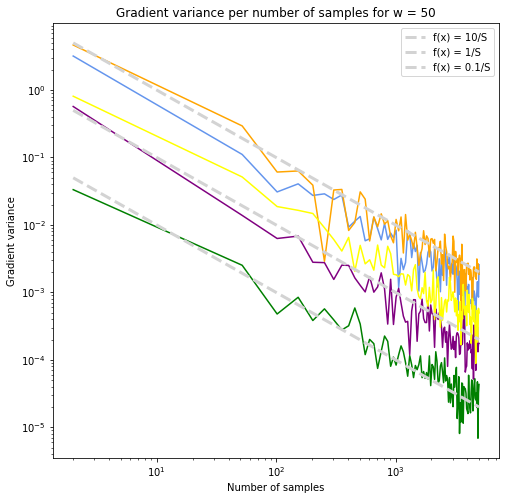

In [7]:
plt.figure(figsize=(8,8))
plt.plot(ns, lr_mu_vars[:, 100], color="cornflowerblue")
plt.plot(ns, lr_mu_vars[:, 50], color="orange")
plt.plot(ns, lr_mu_vars[:, 500], color="green")
plt.plot(ns, lr_mu_vars[:, 300], color="purple")
plt.plot(ns, lr_mu_vars[:, 200], color="yellow")
plt.plot(ns, [(10 / (1 * x)) for x in ns], color="lightgray", label="f(x) = 10/S", linestyle="dashed", linewidth=3)
plt.plot(ns, [(1 / (1 * x)) for x in ns], color="lightgray", label="f(x) = 1/S", linestyle="dashed", linewidth=3)
plt.plot(ns, [(1 / (10 * x)) for x in ns], color="lightgray", label="f(x) = 0.1/S", linestyle="dashed", linewidth=3)
plt.xlabel("Number of samples")
plt.ylabel("Gradient variance")
plt.xscale("log")
plt.yscale("log")
plt.title(f"Gradient variance per number of samples for w = {w}")
plt.legend()
plt.show()

## Gradient Verification

### Visualizing LR and RP gradients

In [8]:
w = 50.0

xs = jnp.linspace(RANGE_START, RANGE_END, NUM_INPUTS)

num_samples = 1000
num_batches = 10

means = jnp.stack([jnp.full((num_samples,), x) for x in xs])
variances = jnp.full((NUM_INPUTS, num_samples), VARIANCE)

rp_mus, rp_vars = get_rp_gradients(means, variances, w, num_samples, NUM_INPUTS)
rp_mu_means = rp_mus.mean(axis=1)

lr_mus, lr_vars = get_lr_gradients(means, variances, xs, w, num_samples, NUM_INPUTS)
lr_mu_means = lr_mus.mean(axis=1)

rp_mu_vars,_ = get_rp_grad_var(means, variances, w, num_samples, NUM_INPUTS, num_batches)
lr_mu_vars,_ = get_lr_grad_var(means, variances, xs, w, num_samples, NUM_INPUTS, num_batches)

Text(0.5, 1.0, 'w: 50.0')

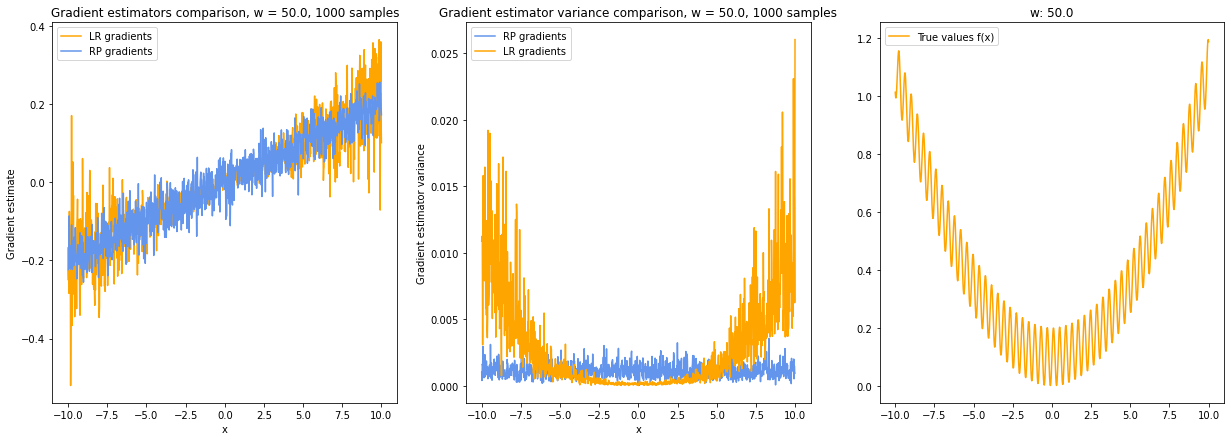

In [9]:
fig = plt.figure(figsize=(21, 7))
ax = fig.subplots(1,3)

# Gradients
ax[0].plot(xs, lr_mu_means, color="orange", label="LR gradients")
ax[0].plot(xs, rp_mu_means, color="cornflowerblue", label="RP gradients")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Gradient estimate")
ax[0].set_title(f"Gradient estimators comparison, w = {w}, {num_samples} samples")
ax[0].legend()

# Gradient variance
ax[1].plot(xs, rp_mu_vars, color="cornflowerblue", label="RP gradients")
ax[1].plot(xs, lr_mu_vars, color="orange", label="LR gradients")
ax[1].set_xlabel("x")
ax[1].set_ylabel("Gradient estimator variance")
ax[1].set_title(f"Gradient estimator variance comparison, w = {w}, {num_samples} samples")
ax[1].legend()

# Differentiated function
true_f = foo(xs, w)

ax[2].plot(xs, true_f, color='orange', label='True values f(x)')
ax[2].legend()
ax[2].set_title(f"w: {w}")

### Absolute difference between LR and RP gradients

In [10]:

ns = np.linspace(1e1, 1e5, 50, dtype=int)

mu_diffs = np.zeros((len(ns),))
var_diffs = np.zeros((len(ns),))

last_n = ns[-1]
means = jnp.stack([jnp.full((last_n,), x) for x in xs])
variances = jnp.full((NUM_INPUTS, last_n), VARIANCE)

for i, N in enumerate(ns):
    if i % 10 == 0:
        print(f"Step: {i}")

    means = jnp.stack([jnp.full((N,), x) for x in xs])
    variances = jnp.full((NUM_INPUTS, N), VARIANCE)
    
    rp_mus, rp_vars = get_rp_gradients(means, variances, w, N, NUM_INPUTS)
    rp_mu_mean = rp_mus.mean(axis=1)
    lr_mus, lr_vars = get_lr_gradients(means, variances, xs, w, N, NUM_INPUTS)
    lr_mu_mean = lr_mus.mean(axis=1)
    
    mu_diff = jnp.absolute(rp_mu_mean - lr_mu_mean).mean()
    mu_diffs[i] = mu_diff
    
    var_diff = jnp.absolute(rp_vars.mean(axis=1) - lr_vars.mean(axis=1)).mean()
    var_diffs[i] = var_diff

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40


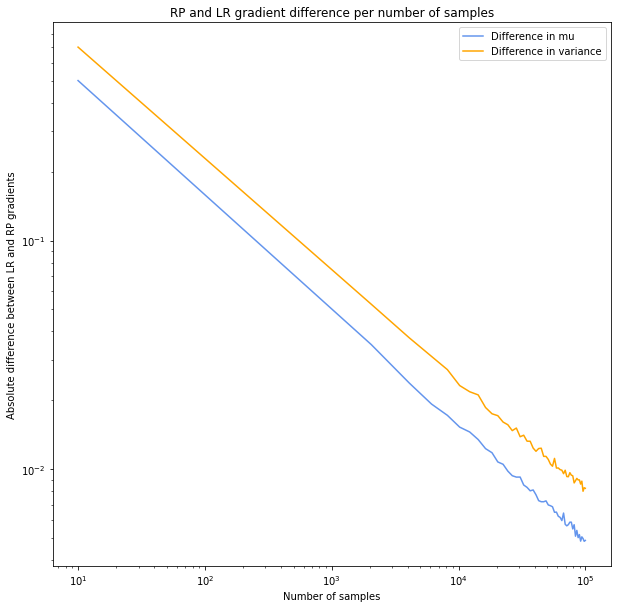

In [11]:
plt.figure(figsize=(10, 10))
plt.plot(ns, mu_diffs, color="cornflowerblue", label="Difference in mu")
plt.plot(ns, var_diffs, color="orange", label="Difference in variance")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of samples")
plt.ylabel("Absolute difference between LR and RP gradients")
plt.legend()
plt.title("RP and LR gradient difference per number of samples")
plt.show()

### Testing gradient values

In this section, we use a linear function
$$ f(x) = 3 * x + 4$$
to convolve with a one dimensional zero-mean gaussian $\mathcal{N}(0, \sigma^2)$ centered at each input point $i_n$ as
$$ \mathbb{E}_{x \sim \mathcal{N}(i_n, \sigma^2)} [f(x)]$$

This allows to compute the gradient $ \nabla_{\mu, \sigma} \mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [f(x)]$ in closed-form, and then compare it to our RP and LR gradient estimators.

For the closed-form, the results can be computed as follows:
- $$ \nabla_{\mu} \mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [f(x)] = \nabla_{\mu} (\mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [3x + 4]) = \nabla_{\mu} (3 * \mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [x] + 4) = \nabla_{\mu} (3 * \mu + 4) = 3 $$
- $$ \nabla_{\sigma} \mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [f(x)] = \nabla_{\sigma} (\mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [3x + 4]) = \nabla_{\sigma} (3 * \mathbb{E}_{x \sim \mathcal{N}(\mu, \sigma^2)} [x] + 4) = \nabla_{\sigma} (3 * \mu + 4) = 0 $$

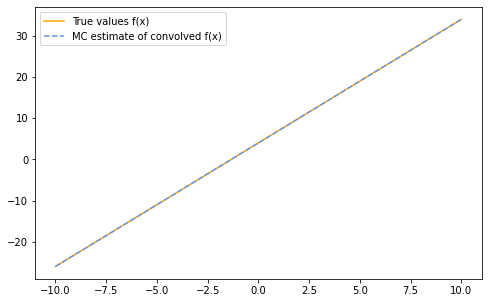

In [12]:
xs = jnp.linspace(RANGE_START, RANGE_END, NUM_INPUTS)

mc_f = mc_linear_foo(xs, VARIANCE, NUM_INPUTS, N)
true_f = linear_foo(xs)

plt.figure(figsize=(8,5))
plt.plot(xs, true_f, color='orange', label='True values f(x)')
plt.plot(xs, mc_f, color='cornflowerblue', label='MC estimate of convolved f(x)', linestyle='dashed')
plt.legend()    
plt.show()

In [13]:
xs = jnp.linspace(RANGE_START, RANGE_END, NUM_INPUTS)
num_samples = 1000

means = jnp.stack([jnp.full((num_samples,), x) for x in xs])
variances = jnp.full((NUM_INPUTS, num_samples), VARIANCE)

rp_mus, rp_vars = get_rp_linear_foo_gradients(means, variances, num_samples, NUM_INPUTS)
rp_mu_means = rp_mus.mean(axis=1)
rp_var_means = rp_vars.mean(axis=1)

lr_mus, lr_vars = get_lr_linear_foo_gradients(means, variances, xs, num_samples, NUM_INPUTS)
lr_mu_means = lr_mus.mean(axis=1)
lr_var_means = lr_vars.mean(axis=1)

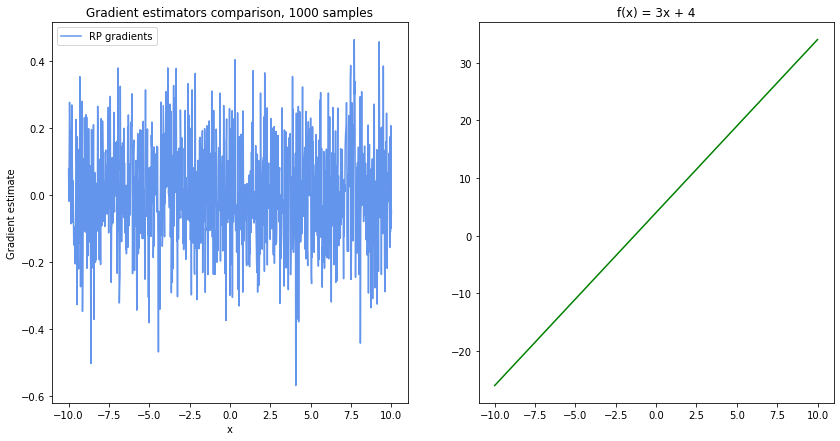

In [14]:
fig = plt.figure(figsize=(14, 7))
ax = fig.subplots(1,2)

# Gradients
# ax[0].plot(xs, lr_mu_means, color="orange", label="LR gradients")
# ax[0].plot(xs, lr_mu_grad_theory, color="green", label="test", linestyle="dashed")
# ax[0].plot(xs, rp_mu_means, color="cornflowerblue", label="RP gradients")
# ax[0].plot(xs, lr_var_means, color="orange", label="LR gradients")
ax[0].plot(xs, rp_var_means, color="cornflowerblue", label="RP gradients")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Gradient estimate")
ax[0].set_title(f"Gradient estimators comparison, {num_samples} samples")
ax[0].legend()

# Monte-Carlo smoothed estimate of f
true_f = linear_foo(xs)
ax[1].plot(xs, true_f, color='green')
ax[1].set_title("f(x) = 3x + 4")

plt.show()

In [15]:
ns = np.linspace(2, 5000, 100, dtype=int)

rp_errors = np.zeros((len(ns), 2, NUM_INPUTS))
lr_errors = np.zeros((len(ns), 2, NUM_INPUTS))

for i, num_samples in enumerate(ns):
    if i % 10 == 0:
        print(f"Step: {i}")

    means = jnp.stack([jnp.full((num_samples,), x) for x in xs])
    variances = jnp.full((NUM_INPUTS, num_samples), VARIANCE)

    rp_mu, rp_var = get_rp_linear_foo_gradients(means, variances, num_samples, NUM_INPUTS)
    rp_mu, rp_var = rp_mu.mean(axis=1), rp_var.mean(axis=1)
    
    rp_errors[i, 0, :] = np.abs(rp_mu - np.full_like(rp_mu, 3))**2 
    rp_errors[i, 1 ,:] = np.abs(rp_var - np.full_like(rp_var, 0))**2
    
    lr_mu, lr_var = get_lr_linear_foo_gradients(means, variances, xs, num_samples, NUM_INPUTS)
    lr_mu, lr_var = lr_mu.mean(axis=1), lr_var.mean(axis=1)
    lr_errors[i, 0] = np.abs(lr_mu - np.full_like(lr_mu, 3))**2
    lr_errors[i, 1] = np.abs(lr_var - np.full_like(lr_var, 0))**2

Step: 0
Step: 10
Step: 20
Step: 30
Step: 40
Step: 50
Step: 60
Step: 70
Step: 80
Step: 90


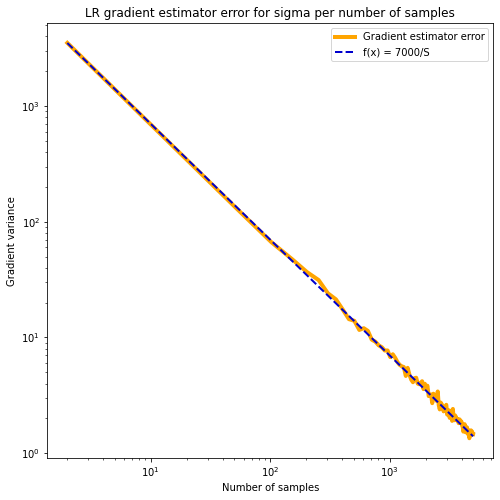

In [16]:
plt.figure(figsize=(8,8))
plt.plot(ns, lr_errors[:, 1,:].mean(axis=1), color="orange", label="Gradient estimator error", linewidth=4)
plt.plot(ns, [(7000 / (1 * x)) for x in ns], color="mediumblue", label="f(x) = 7000/S", linestyle="dashed", linewidth=2)
# plt.plot(ns, [(250 / (1 * x)) for x in ns], color="cornflowerblue", label="f(x) = 250/S", linestyle="dashed", linewidth=3)
# plt.plot(ns, [(50 / (1 * x)) for x in ns], color="seagreen", label="f(x) = 50/S", linestyle="dashed", linewidth=3)
plt.xlabel("Number of samples")
plt.ylabel("Gradient variance")
plt.xscale("log")
plt.yscale("log")
plt.title(f"LR gradient estimator error for sigma per number of samples")
plt.legend()
plt.savefig("lr_error_sigma.jpg", bbox_inches='tight')
plt.show()